#### AML Assignment 03
#### **Deep Reinforcement Learning for OpenAI Gym**

Team Members:

1. Chandranath Bhattacharya - MDS202318
2. Salokya Deb - MDS202341
3. Soumyajoy Kundu - MDS202349




In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.pyplot as plt

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install swig
!pip install gym[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.6 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376473 sha256=d0476f0834387ce3350c952ac107889065b2f38aae5391d8cdac603f8aa7bcbd
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.1
    Uninstalling pygame-2.6.1:
      Successfully uninstalled pygame-2.6.1


In [ ]:
from gym import Env

all_envs = gym.envs.registry.all()
env_ids = [env_spec.id for env_spec in all_envs]
print(sorted(env_ids))
print()

['Acrobot-v1', 'Ant-v2', 'Ant-v3', 'Ant-v4', 'BipedalWalker-v3', 'BipedalWalkerHardcore-v3', 'Blackjack-v1', 'CarRacing-v2', 'CartPole-v0', 'CartPole-v1', 'CliffWalking-v0', 'FrozenLake-v1', 'FrozenLake8x8-v1', 'HalfCheetah-v2', 'HalfCheetah-v3', 'HalfCheetah-v4', 'Hopper-v2', 'Hopper-v3', 'Hopper-v4', 'Humanoid-v2', 'Humanoid-v3', 'Humanoid-v4', 'HumanoidStandup-v2', 'HumanoidStandup-v4', 'InvertedDoublePendulum-v2', 'InvertedDoublePendulum-v4', 'InvertedPendulum-v2', 'InvertedPendulum-v4', 'LunarLander-v2', 'LunarLanderContinuous-v2', 'MountainCar-v0', 'MountainCarContinuous-v0', 'Pendulum-v1', 'Pusher-v2', 'Pusher-v4', 'Reacher-v2', 'Reacher-v4', 'Swimmer-v2', 'Swimmer-v3', 'Swimmer-v4', 'Taxi-v3', 'Walker2d-v2', 'Walker2d-v3', 'Walker2d-v4']



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


### Arcobot

The Acrobot is a two-joint, two-link mechanism, and the goal is to get the end of the mechanism
to touch the horizontal height marker.

![](https://i.imgur.com/0bdwRIt.gif)

In [ ]:
# Setup the environment
env = gym.make('Acrobot-v1', render_mode='rgb_array')

#### Observation Space
The observation provides information about the two joint angles and their angular velocities.

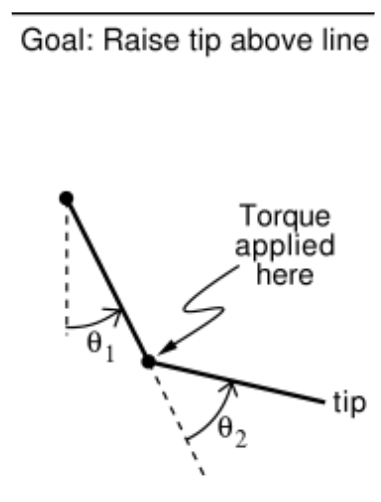

| Observation                | Min                 | Max              |
|----------------------------|---------------------|------------------|
| Cosine of `theta1`           | -1                  | 1                |
| Sine of `theta1`             | -1                  | 1                |
| Cosine of `theta2`           | -1                  | 1                |
| Sine of `theta2`             | -1                  | 1                |
| Angular velocity of `theta1` | ~ -12.567 (-4 * pi) | ~ 12.567 (4 * pi)|
| Angular velocity of `theta2` | ~ -28.274 (-9 * pi) | ~ 28.274 (9 * pi)|

Where:

- `theta1` is the angle of the first joint, where an angle of 0 indicates the first link is pointing directly downwards.
- `theta2` is relative to the angle of the first link. An angle of 0 corresponds to having the same angle between the two links.

In [ ]:
print("Observation space:", env.observation_space)
print("Action Space:", env.action_space)
print("Observation Space High:", env.observation_space.high)
print("Observation Space Low:", env.observation_space.low)

Observation space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
Action Space: Discrete(3)
Observation Space High: [ 1.        1.        1.        1.       12.566371 28.274334]
Observation Space Low: [ -1.        -1.        -1.        -1.       -12.566371 -28.274334]


#### General Information
This information is from the official Gym documentation. [Link](https://gymnasium.farama.org/environments/classic_control/acrobot/)

| Feature Category  | Details                                |
|-------------------|----------------------------------------|
| Action Space      | Discrete(3)                            |
| Observation Shape | (6,)                                   |
| Observation High  | [1 1 1 1 12.566371 28.274334]          |
| Observation Low   | [-1 -1 -1 -1 -12.566371 -28.274334]    |
| Import            | `gym.make("Acrobot-v1")`               |

#### Description of Environment

The Acrobot environment consists of a two-link structure, with the joint between the two links actuated. Initially, both links hang downwards. The goal is to apply torques on the actuated joint to swing the free end of the outer-link above a line that is a certain height above the base.

#### Action Space
The action is the torque applied to the joint connecting the two links.

| Action  | Result                | Unit        |
|---------|-----------------------|-------------|
| 0       | Apply -1 torque       | Torque (N m)|
| 1       | Apply 0 torque        | Torque (N m)|
| 2       | Apply 1 torque        | Torque (N m)|



#### Rewards
* All steps that do not reach the goal incur a reward of -1.
* Reaching the goal results in termination with a reward of 0.
* The reward threshold is -100.


#### Starting State
Each parameter in the state (theta1, theta2, and the two angular velocities) is initialized uniformly between -0.1 and 0.1. This implies that both links are pointing downwards with some initial stochasticity.

#### Episode Termination
The episode ends if:

1. The free end reaches the target height, which is defined by: `- cos(theta1) - cos(theta2 + theta1) > 1.0`.
2. The episode length is greater than 500 steps.

**To save an episode as gif and display it later**

In [ ]:
import imageio
import os
from IPython.display import HTML

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):
    """Takes a list of frames (each frame can be generated with the `env.render()` function from OpenAI gym)
    and converts it into GIF, and saves it to the specified location.
    Code adapted from this gist: https://gist.github.com/botforge/64cbb71780e6208172bbf03cd9293553
    Args:
        frames (list): A list of frames generated with the env.render() function
        path (str, optional): The folder in which to save the generated GIF. Defaults to './'.
        filename (str, optional): The target filename. Defaults to 'gym_animation.gif'.
    """
    # Resize frames to a common size using Pillow
    # Get the size of the first frame
    first_frame_shape = frames[0].shape[:2]

    # Resize all frames to match the first frame's size
    resized_frames = [np.array(Image.fromarray(frame).resize(first_frame_shape)) for frame in frames]

    imageio.mimwrite(os.path.join(path, filename), resized_frames, fps=15)


frame shape:  (1, (500, 500, 3))


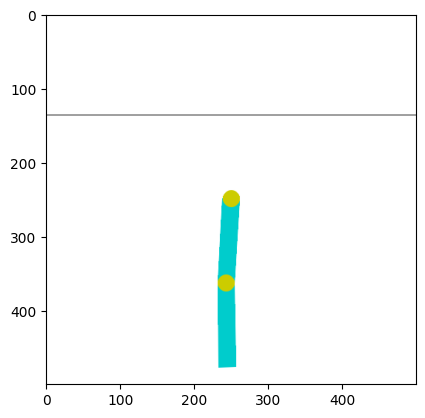

In [ ]:
env.reset()
frame = env.render()
print("frame shape: ", (len(frame),frame[0].shape))

# Squeeze the frame to remove the extra dimension
frame = frame[0]

plt.imshow(frame)
plt.grid(False)

In [ ]:
frames = []
env.reset()
total_reward = 0
for i in range(100):
    action = env.action_space.sample()

    # Modify this line to unpack only 4 values
    next_state, reward, done, info = env.step(action)

    # The 'done' value now represents both terminated and truncated
    total_reward += reward
    frame = env.render()
    frames.append(frame)
    if done:
        break

print("Game terminated after", len(frames), " steps with reward ", total_reward)

Game terminated after 100  steps with reward  -100.0


### Hyperparameters

- **`n_episodes`**: 2000  
   - The total number of training episodes. Each episode represents one complete interaction sequence between the agent and the environment until termination.

- **`learning_rate`**: 0.001  
   - Determines the step size at which the agent updates its Q-values. A smaller value ensures gradual learning, while a larger value speeds up learning but may lead to instability.

- **`gamma`**: 0.99  
   - The discount factor that determines the importance of future rewards relative to immediate rewards. A value close to 1.0 ensures the agent considers long-term rewards.

- **`eps_start`**: 1.0  
   - The initial value of epsilon for the epsilon-greedy policy. It represents the exploration rate, where the agent starts with full exploration.

- **`epsilon_decay`**: 0.995  
   - The rate at which epsilon decreases after each episode. A lower epsilon over time encourages the agent to shift from exploration to exploitation.

- **`eps_end`**: 0.01  
   - The minimum value of epsilon, ensuring the agent maintains a small level of exploration even after long training periods.

- **`batch_size`**: 64  
   - The number of experiences sampled from the replay buffer during each training step. A larger batch size can stabilize learning but increases computational cost.

- **`memory_size`**: 10000  
   - The size of the replay buffer, which stores past experiences `(state, action, reward, next_state, done)`. Larger memory allows the agent to learn from a wider range of past experiences.


In [ ]:
# Hyperparameters
n_episodes = 2000
learning_rate = 0.001
gamma = 0.99
eps_start=1.0
epsilon_decay = 0.995
eps_end=0.01
batch_size = 64
memory_size = 10000

### Q-network

In [4]:
import torch

class DQN(torch.nn.Module):
    '''
    This class defines a deep Q-network (DQN), a type of artificial neural network used in reinforcement learning.
    The DQN is used to estimate the Q-values, which represent the expected return for each action in each state.

    Parameters
    ----------
    state_size: int, default=6
        The size of the state space.
    action_size: int, default=4
        The size of the action space.
    hidden_size: int, default=64
        The size of the hidden layers in the network.
    '''
    def __init__(self, state_size=6, action_size=3, hidden_size=64):
        '''
        Initialize a network with the following architecture:
            Input layer (state_size, hidden_size)
            Hidden layer 1 (hidden_size, hidden_size)
            Output layer (hidden_size, action_size)
        '''
        super(DQN, self).__init__()
        self.layer1 = torch.nn.Linear(state_size, hidden_size)
        self.layer2 = torch.nn.Linear(hidden_size, hidden_size)
        self.layer3 = torch.nn.Linear(hidden_size, action_size)

    def forward(self, state):
        '''
        Define the forward pass of the DQN. This function is called when the network is called to estimate Q-values.

        Parameters
        ----------
        state: torch.Tensor
            The state for which to estimate the Q-values.

        Returns
        -------
        torch.Tensor
            The estimated Q-values for each action in the input state.
        '''
        x = torch.relu(self.layer1(state))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

In [6]:
from torchsummary import summary
import torch

# Instantiate the model
state_size = 6
action_size = 3
hidden_size = 64
model = DQN(state_size, action_size, hidden_size)

# Define input size (batch size 1, state size 6)
input_size = (1, state_size)

# Move the model to the appropriate device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # Move model to the specified device

# Create input tensor on the correct device
input_tensor = torch.randn(input_size, device=device) # create a random input tensor and send to the model's device

# Print the model summary, passing the input tensor to the `summary` function
summary(model, input_size=input_tensor.shape)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 64]             448
            Linear-2                [-1, 1, 64]           4,160
            Linear-3                 [-1, 1, 3]             195
Total params: 4,803
Trainable params: 4,803
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


### Replay Memory
* We'll be using experience replay memory for training our DQN.
* It stores the transitions that the agent observes, allowing us to reuse this data later.
* By sampling from it randomly, the transitions that build up a batch are decorrelated.

It has been shown that this greatly stabilizes and improves the DQN training procedure.

In [ ]:
import numpy as np
import random
from collections import deque

class ReplayBuffer:
    '''
    This class represents a replay buffer, a type of data structure commonly used in reinforcement learning algorithms.
    The buffer stores past experiences in the environment, allowing the agent to sample and learn from them at later times.
    This helps to break the correlation of sequential observations and stabilize the learning process.

    Parameters
    ----------
    buffer_size: int, default=10000
        The maximum number of experiences that can be stored in the buffer.
    '''
    def __init__(self, buffer_size=10000):
        self.buffer = deque(maxlen=buffer_size)

    def push(self, state, action, reward, next_state, done):
        '''
        Add a new experience to the buffer. Each experience is a tuple containing a state, action, reward,
        the resulting next state, and a done flag indicating whether the episode has ended.

        Parameters
        ----------
        state: array-like
            The state of the environment before taking the action.
        action: int
            The action taken by the agent.
        reward: float
            The reward received after taking the action.
        next_state: array-like
            The state of the environment after taking the action.
        done: bool
            A flag indicating whether the episode has ended after taking the action.
        '''
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        '''
        Randomly sample a batch of experiences from the buffer. The batch size must be smaller or equal to the current number of experiences in the buffer.

        Parameters
        ----------
        batch_size: int
            The number of experiences to sample from the buffer.

        Returns
        -------
        tuple of numpy.ndarray
            A tuple containing arrays of states, actions, rewards, next states, and done flags.
        '''
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return np.stack(states), actions, rewards, np.stack(next_states), dones

    def __len__(self):
        '''
        Get the current number of experiences in the buffer.

        Returns
        -------
        int
            The number of experiences in the buffer.
        '''
        return len(self.buffer)

In [ ]:
class DQNAgent:
    '''
    This class represents a Deep Q-Learning agent that uses a Deep Q-Network (DQN) and a replay memory to interact
    with its environment.

    Parameters
    ----------
    state_size: int, default=8
        The size of the state space.
    action_size: int, default=4
        The size of the action space.
    hidden_size: int, default=64
        The size of the hidden layers in the network.
    learning_rate: float, default=1e-3
        The learning rate for the optimizer.
    gamma: float, default=0.99
        The discount factor for future rewards.
    buffer_size: int, default=10000
        The maximum size of the replay memory.
    batch_size: int, default=64
        The batch size for learning from the replay memory.
    '''
    def __init__(self, state_size=6, action_size=3, hidden_size=64,
                 learning_rate=1e-3, gamma=0.99, buffer_size=10000, batch_size=64):
        # Select device to train on (if CUDA available, use it, otherwise use CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Discount factor for future rewards
        self.gamma = gamma

        # Batch size for sampling from the replay memory
        self.batch_size = batch_size

        # Number of possible actions
        self.action_size = action_size

        # Initialize the Q-Network and Target Network with the given state size, action size and hidden layer size
        # Move the networks to the selected device
        self.q_network = DQN(state_size, action_size, hidden_size).to(self.device)
        self.target_network = DQN(state_size, action_size, hidden_size).to(self.device)

        # Set weights of target network to be the same as those of the q network
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Set target network to evaluation mode
        self.target_network.eval()

        # Initialize the optimizer for updating the Q-Network's parameters
        self.optimizer = torch.optim.Adam(self.q_network.parameters(), lr=learning_rate)

        # Initialize the replay memory
        self.memory = ReplayBuffer(buffer_size)

    def step(self, state, action, reward, next_state, done):
        '''
        Perform a step in the environment, store the experience in the replay memory and potentially update the Q-network.

        Parameters
        ----------
        state: array-like
            The current state of the environment.
        action: int
            The action taken by the agent.
        reward: float
            The reward received after taking the action.
        next_state: array-like
            The state of the environment after taking the action.
        done: bool
            A flag indicating whether the episode has ended after taking the action.
        '''
        # Store the experience in memory
        self.memory.push(state, action, reward, next_state, done)

        # If there are enough experiences in memory, perform a learning step
        if len(self.memory) > self.batch_size:
            self.update_model()

    def act(self, state, eps=0.):
        '''
        Choose an action based on the current state and the epsilon-greedy policy.

        Parameters
        ----------
        state: array-like
            The current state of the environment.
        eps: float, default=0.
            The epsilon for the epsilon-greedy policy. With probability eps, a random action is chosen.

        Returns
        -------
        int
            The chosen action.
        '''
        # If a randomly chosen value is greater than eps
        if random.random() > eps:
            # Convert state to a PyTorch tensor and set network to evaluation mode
            state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
            self.q_network.eval()

            # With no gradient updates, get the action values from the DQN
            with torch.no_grad():
                action_values = self.q_network(state)

            # Revert to training mode and return action
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())
        else:
            # Return a random action for random value > eps
            return random.choice(np.arange(self.action_size))

    def update_model(self):
        '''
        Update the Q-network based on a batch of experiences from the replay memory.
        '''
        # Sample a batch of experiences from memory
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)

        # Convert numpy arrays to PyTorch tensors
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(np.array(actions)).long().to(self.device)
        rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
        next_states = torch.from_numpy(next_states).float().to(self.device)
        dones = torch.from_numpy(np.array(dones).astype(np.uint8)).float().to(self.device)

        # Get Q-values for the actions that were actually taken
        q_values = self.q_network(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        # Get maximum Q-value for the next states from target network
        next_q_values = self.target_network(next_states).max(1)[0].detach()

        # Compute the expected Q-values
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        # Compute the loss between the current and expected Q values
        loss = torch.nn.MSELoss()(q_values, expected_q_values)

        # Zero all gradients
        self.optimizer.zero_grad()

        # Backpropagate the loss
        loss.backward()

        # Step the optimizer
        self.optimizer.step()

    def update_target_network(self):
        '''
        Update the weights of the target network to match those of the Q-network.
        '''
        self.target_network.load_state_dict(self.q_network.state_dict())

### Training

In [ ]:
def train(agent, env, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, target_update=10):
    '''
    Train a DQN agent.

    Parameters
    ----------
    agent: DQNAgent
        The agent to be trained.
    env: gym.Env
        The environment in which the agent is trained.
    n_episodes: int, default=2000
        The number of episodes for which to train the agent.
    eps_start: float, default=1.0
        The starting epsilon for epsilon-greedy action selection.
    eps_end: float, default=0.01
        The minimum value that epsilon can reach.
    eps_decay: float, default=0.995
        The decay rate for epsilon after each episode.
    target_update: int, default=10
        The frequency (number of episodes) with which the target network should be updated.

    Returns
    -------
    list of float
        The total reward obtained in each episode.
    '''

    # Initialize the scores list and scores window
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start

    # Loop over episodes
    for i_episode in range(1, n_episodes + 1):

        # Reset environment and score at the start of each episode
        state, _ = env.reset(return_info = True)
        state = state
        score = 0

        # Loop over steps
        while True:

            # Select an action using current agent policy then apply in environment
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)

            # Update the agent, state and score
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            # End the episode if done
            if done:
                break

        # At the end of episode append and save scores
        scores_window.append(score)
        scores.append(score)

        # Decrease epsilon
        eps = max(eps_end, eps_decay * eps)

        # Print some info
        print(f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}", end="")

        # Update target network every target_update episodes
        if i_episode % target_update == 0:
            agent.update_target_network()

        # Print average score every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        # This environment is considered to be solved for a mean score of -100 or greater, so stop training.
        if i_episode % 100 == 0 and np.mean(scores_window) >= -100:
            break

    return scores

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Make an environment
env = gym.make('Acrobot-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initilize a DQN agent
agent = DQNAgent(state_size, action_size)

# Train it
scores = train(agent, env)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: -473.82
Episode 200	Average Score: -376.03
Episode 300	Average Score: -327.23
Episode 400	Average Score: -232.96
Episode 500	Average Score: -275.87
Episode 600	Average Score: -154.37
Episode 700	Average Score: -117.66
Episode 800	Average Score: -98.29


#### Plotting the training process

In [ ]:
import matplotlib.pyplot as plt

def plot_training(scores, window=100):
    """
    Plots the training progress of the agent.

    Parameters
    ----------
    scores: list of float
        The scores (total rewards) from each episode.
    window: int, default=100
        The window size for calculating the moving average.
    """
    # Compute moving average of scores
    moving_avg = [np.mean(scores[max(0, i-window):i+1]) for i in range(len(scores))]

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(scores, label="Score per Episode")
    plt.plot(moving_avg, label=f"{window}-Episode Moving Average", linewidth=2, color='orange')
    plt.axhline(y=-100, color='r', linestyle='--', label="Reward Threshold (-100)")
    plt.title("Training Progress of DQN on Acrobot")
    plt.xlabel("Episode")
    plt.ylabel("Score (Total Reward)")
    plt.legend()
    # plt.grid()
    plt.show()

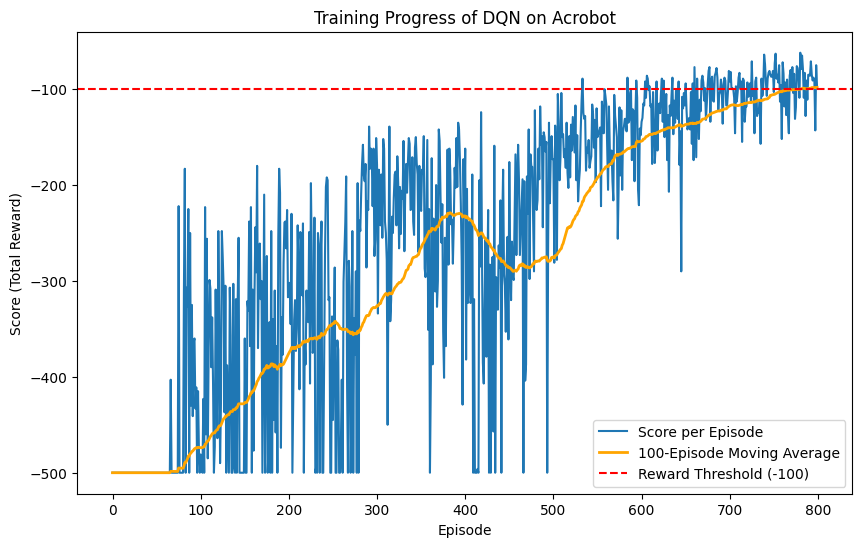

In [ ]:
# Plot the results
plot_training(scores)

**Comments:**

* The DQN agent successfully learned to solve the Acrobot environment by achieving a moving average above -100.
* Learning was gradual, with steady progress over 600 - 800 episodes.
* The performance plateaued after the threshold, suggesting the agent's learning stabilized and further improvements became minimal.

* Saving the trained `agent` and respective `scores` as `.pkl` file for future use.

In [ ]:
import pickle

# Save the agent
with open('dqn_agent.pkl', 'wb') as f:
    pickle.dump(agent, f)

# Save the scores
with open('scores.pkl', 'wb') as f:
    pickle.dump(scores, f)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Play Game
* Below are some episodes which were played with the trained agent
* For every epsiode, the reward is greater than -100, which concludes that the agent is able to terminate the game within 100 steps.

In [ ]:
import gym
import matplotlib.pyplot as plt

def save_final_frame(agent, env, save_path="final_frame.png"):
    '''
    Let the agent play one episode and save the final environment frame when terminated.

    Parameters
    ----------
    agent: DQNAgent
        The trained agent.
    env: gym.Env
        The environment.
    save_path: str
        Path to save the final frame image.
    '''

    state, _ = env.reset(return_info=True)
    frames = []  # To store frames if needed
    total_reward = 0

    while True:
        # Render the environment frame as an image (RGB array)
        frame = env.render(mode='rgb_array')
        frames.append(frame)

        # Agent acts deterministically
        action = agent.act(state, eps=0.0)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        total_reward += reward

        # Save the last frame when the episode ends
        if done:
            print(f"Episode finished with total reward: {total_reward:.2f}")

            # Plot and save the final frame
            plt.imshow(frame)
            plt.axis('off')  # Remove axes
            plt.title("Frame at Termination")
            plt.savefig(save_path, bbox_inches='tight')
            print(f"Final frame saved at: {save_path}")
            break

    env.close()

Episode finished with total reward: -87.00
Final frame saved at: final_frame.png


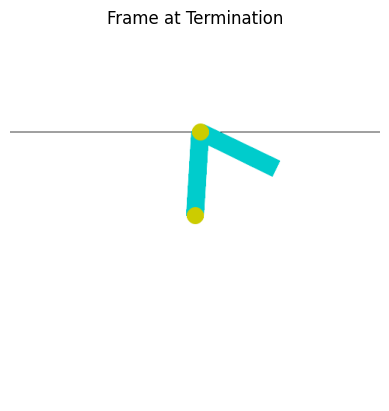

In [ ]:
save_final_frame(agent, env, save_path="final_frame_1.png")

Episode finished with total reward: -72.00
Final frame saved at: final_frame_2.png


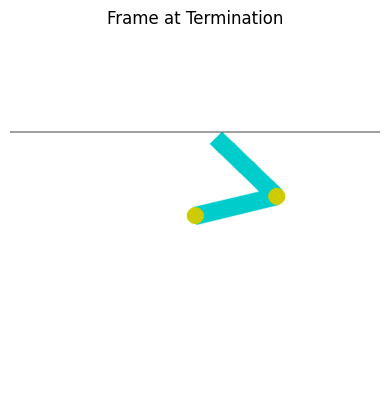

In [ ]:
save_final_frame(agent, env, save_path="final_frame_2.png")

Episode finished with total reward: -96.00
Final frame saved at: final_frame_3.png


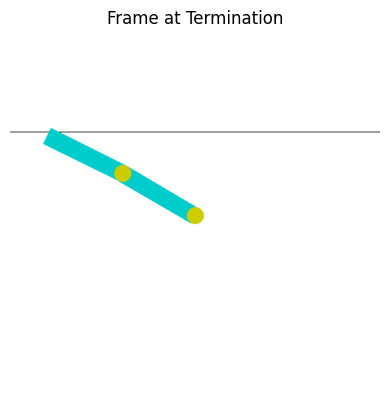

In [ ]:
save_final_frame(agent, env, save_path="final_frame_3.png")

### Conclusion

1. **Successful Learning**:  
   The DQN agent successfully solved the Acrobot environment by achieving rewards better than the threshold of **-100** (e.g., reward of > 100 in the above games).  

2. **Steady Training Progress**:  
   The 100-episode moving average showed gradual improvement, stabilizing around **episode 600 - 800**, indicating efficient learning.  

3. **Consistent Performance**:  
   The trained agent consistently reaches termination with rewards above the threshold, demonstrating robustness and reliability.  

4. **Visual Confirmation**:  
   The final frame of the games played by trained agent shows the Acrobot reaching its target state with the second link above the line, validating the agent's success in solving the environment.
